In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

## Assumptions made by kk-means models
kk-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward. It also assumes all clusters have similar variances. See these pictures of clusters that do and do not fit the kk-means isotropic and variance assumptions.

## Speed
High-dimensional data tends to make kk-means run more slowly because it is more computationally demanding to measure the distance between each data point and the mean in a higher-dimensional space. A common practice is to run a PCA on the data first to reduce dimensionality, and then search for clusters in the reduced data.

If you don't want to reduce dimensions but you do have limited computational power or time, a different option is MiniBatchKMeans in sklearn, which randomly samples subsets of the training data in each iteration. The loop steps are similar to those in the original:

1) Assign the samples to their nearest centroids.

2) Update the centroids based on the streaming average of all of the samples that have been assigned to the centroid so far.

The solution you get will be a little worse than regular kk-means but drastically faster.

## Applying the model
Let's try kk-means on some [heart disease](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) data from the UC Irvine Machine Learning Repository. Our goal will be to create a kk-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)



To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

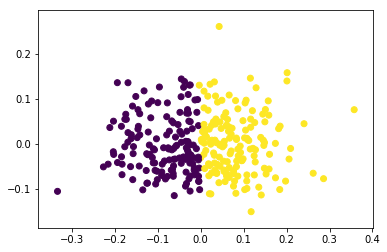

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [3]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Looks like this model isn't doing very well. We're correctly classifying 182 cases, but mis-classifying 120 of the cases!

Now let's try MiniBatch:

In [4]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0       13  154
1      136    0


This marks a significant change. How substantial is the computational performance improvement? Try re-running the  kk -means and mini batch  kk -means models and timing their execution. Check out the [%timeit](https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit) magic for helpful timing tools.

In [5]:
from timeit import Timer
# kk-means
t=Timer(lambda: KMeans(n_clusters=2, random_state=42).fit_predict(X_pca))
print('The time for the kk-means method is {} milliseconds'.format(t.timeit(number=1)))

# mini batch
t2=Timer(lambda: minibatchkmeans.predict(X_pca))
print('The time for the mini batch method is {} milliseconds'.format(t2.timeit(number=1)))

The time for the kk-means method is 0.033595675995456986 milliseconds
The time for the mini batch method is 0.0007025040104053915 milliseconds


The mini batch method is faster and more accurate.

# Drill: More clusters?
Your task is to take the  kk -means code here and see what happens when you change the value of  kk . What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor. Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

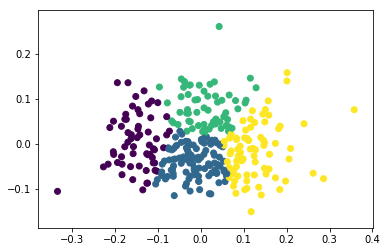

Comparing k-means clusters against the data:
[[40 21  0  0]
 [37 67  0  0]
 [42 20  0  0]
 [20 56  0  0]]


In [6]:
from sklearn.metrics import confusion_matrix
# 4 clusters
# Calculate predicted values.
y_pred_4 = KMeans(n_clusters=4, random_state=42).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_4)
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(confusion_matrix(y_pred_4, y))

The model is correctly predicting 147 cases, and incorrectly predicting 156 cases.

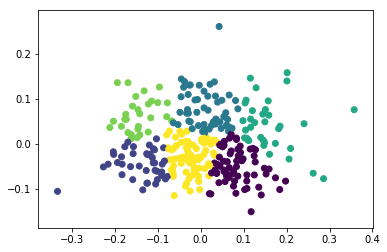

Comparing k-means clusters against the data:
[[14 52  0  0  0  0]
 [20 21  0  0  0  0]
 [34 20  0  0  0  0]
 [14 21  0  0  0  0]
 [23  6  0  0  0  0]
 [34 44  0  0  0  0]]


In [7]:
# 6 clusters
# Calculate predicted values.
y_pred_6 = KMeans(n_clusters=6, random_state=42).fit_predict(X_pca)
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_6)
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(confusion_matrix(y_pred_6, y))

This model correctly predicts 75 cases and incorrectly predicts 228. It seems more clusters make the model less accurate with this data. This is likely becasue there are only 2 possible outcomes.